In [57]:
using Flux
using Flux: onehot, onecold, logitcrossentropy #, throttle, @epochs
using MLDatasets
using Random
using JLD2
using Statistics
using MLJBase
using BSON: @load # for load weights
using Plots
using Zygote
using Distributions

In [77]:
globalFoodSourceFitness = [0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
cumProb

10-element Vector{Float64}:
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0

In [ ]:
function calCumFitness()
    fitnessSum = sum(globalFoodSourceFitness)
    fitnessProb = globalFoodSourceFitness/fitnessSum
    cumProb = cumsum(fitnessProb)
end

In [ ]:
function rouletteWheelSelection()
    fitnessSum = sum(globalFoodSourceFitness)
    fitnessProb = globalFoodSourceFitness/fitnessSum
    cumProb = cumsum(fitnessProb)
    randNum = rand()
    for i in 1:pop
        if randNum <= cumProb[i]
            return i
        end
    end
end

In [78]:
fitnessSum = sum(globalFoodSourceFitness)
    fitnessProb = globalFoodSourceFitness/fitnessSum
    cumProb = cumsum(fitnessProb)

10-element Vector{Float64}:
 0.018181818181818184
 0.05454545454545455
 0.1090909090909091
 0.18181818181818182
 0.2727272727272727
 0.3818181818181818
 0.509090909090909
 0.6545454545454545
 0.8181818181818182
 1.0

In [ ]:

    randNum = rand()
    for i in 1:pop
        if randNum <= cumProb[i]
            return i
        end
    end

Input Data

In [58]:
train_data = JLD2.load_object("data/train_data.jld2");
test_data = JLD2.load_object("data/test_data.jld2");
x_train = JLD2.load_object("data/x_train.jld2");
y_train = JLD2.load_object("data/y_train.jld2");
x_test  = JLD2.load_object("data/x_test.jld2");
y_test  = JLD2.load_object("data/y_test.jld2");

In [76]:
x_train

19×1388 Matrix{Float64}:
 53.0  33.0  79.0  78.0  54.0  43.0  …  78.0  13.0  82.0  44.0  72.0  71.0
 13.7  20.3  19.2  19.7   8.3   8.3     13.3  26.3  22.9  13.3  15.1  39.3
  4.1   5.5   7.0   6.8   6.1   2.6      3.6   9.1  10.1   4.9   4.4   6.1
  1.6   2.4   2.7   2.8   0.1   0.9      1.6   8.1   3.7   1.8   1.7   0.1
  4.0   6.0   6.1   5.3   5.1   2.4      3.1  11.1   8.4   4.0   4.1  11.1
 41.2  39.9  43.4  51.7  50.1  35.6  …  51.7  45.1  43.4  46.0  42.2  33.1
  0.0   0.1   0.0   0.0   0.1   0.1      0.0   0.1   0.8   0.1   0.6   0.1
  0.1   0.8   0.0   0.0   0.1   0.4      0.0   3.1   2.3   0.3   1.9   2.1
 33.3   8.0   0.0   0.0  50.1  21.1      0.0  24.1  36.8  25.0  32.8  48.1
  0.8   0.7   1.7   1.3   2.1   0.8      0.4   5.1   2.0   1.2   0.4   2.1
  1.2   0.9   2.2   2.2   0.1   1.1  …   0.7   5.1   2.3   1.4   0.5   6.1
 68.3  76.7  77.5  59.5  54.1  74.5     60.8  77.1  85.4  82.3  71.1  85.1
  0.2   0.5   1.4   2.2   3.1   0.3      0.8   5.1   0.6   0.3   0.3   2.1


Defind Model to train

In [59]:
model = Chain(Dense(19, 2*19, sigmoid), Dense(2*19, 2)) #define the model 
θ, re = Flux.destructure(model); 
Dimension = size(θ)[1]; #number of parameters

In [60]:
pop = 1000 # number of food sources
tryLimit = 5 # limit of the number of tries
maxCycle = 500 # maximum number of cycles
acc = 1 # acceleration constant

lowerBound = -10 #lower bound of the variables
upperBound = 10; #upper bound of the variables

In [61]:
rng =Random.default_rng()

globalWeights = [Vector{Float64}(undef,Dimension) for _ in 1:pop]; 
globalFoodSourceFitness = zeros(Float64, pop)
globalfoodSourceCount = zeros(Float64, pop)

preCal = upperBound-lowerBound;


In [62]:
function initABC()
    for i in 1:pop
        for j in 1:Dimension
            temp = lowerBound + rand()*preCal
            if temp < lowerBound
                temp = lowerBound
            elseif temp > upperBound
                temp = upperBound
            end
            globalWeights[i][j] = temp
        end
        globalFoodSourceFitness[i] = calculateFitness(train_data, globalWeights[i])
        globalfoodSourceCount[i] = 0
    end
end

initABC (generic function with 1 method)

In [63]:
function FindNewFoodSource(index)
    j = index
    while j == index
        j = rand(1:pop)
    end
    newSource = zeros(Float64,Dimension)
    for i in 1:Dimension
        
        temp = globalWeights[index][i] + acc*rand(Uniform(-1,1))*(globalWeights[index][i]-globalWeights[j][i])
        if temp < lowerBound
            temp = lowerBound;
        elseif temp > upperBound
            temp = upperBound;
        end
        newSource[i] = temp
    end
    updateFoodSource(index, newSource)
end


FindNewFoodSource (generic function with 1 method)

In [64]:
function updateFoodSource(index, newSource)
    localFitness = calculateFitness(train_data, newSource)
    if localFitness > globalFoodSourceFitness[index]
        globalFoodSourceFitness[index] = localFitness
        globalWeights[index] = newSource
        globalfoodSourceCount[index] = 0
    else
        globalfoodSourceCount[index] = globalfoodSourceCount[index]+1
    end
end


updateFoodSource (generic function with 1 method)

In [65]:
# accuracy(model,x,y) = sum(onecold(model(x)) .== onecold(y))/size(x,2)
# accuracy(xy, model) = mean( onecold(model(x)) .== onecold(y) for (x,y) in xy)

# function calculateFitness1(newWeight)
#     return accuracy(train_data, re(newWeight))
# end

In [66]:
loss(model) = (x,y)->Flux.logitcrossentropy(model(x), y)
loss(model,x,y) = loss(model)(x, y)
loss(xy, model) = loss(model)(hcat(map(first,xy)...), hcat(map(last,xy)...))
function calculateFitness(data, newWeight)
    return 1/(1+loss(data, re(newWeight)))
end

calculateFitness (generic function with 2 methods)

In [67]:
function checkRetire()
    for i in 1:pop
        if globalfoodSourceCount[i] > tryLimit
            if i == getBest()
                globalfoodSourceCount[i] = 0
            else
            FindNewFoodSource(i)
            end
        end
    end
end

checkRetire (generic function with 1 method)

In [68]:
function rouletteWheelSelection()
    fitnessSum = sum(globalFoodSourceFitness)
    fitnessProb = globalFoodSourceFitness/fitnessSum
    cumProb = cumsum(fitnessProb)
    randNum = rand()
    for i in 1:pop
        if randNum <= cumProb[i]
            return i
        end
    end
end

rouletteWheelSelection (generic function with 1 method)

In [69]:
function getBest()
    return argmax(globalFoodSourceFitness)
end

getBest (generic function with 1 method)

In [70]:
function employedBeeFindNew()
    for i in 1:pop
        FindNewFoodSource(i)
    end
end

employedBeeFindNew (generic function with 1 method)

In [71]:
function onlookFindNew()
    for i in 1:pop
        index = rouletteWheelSelection()
        FindNewFoodSource(index)
    end
end

onlookFindNew (generic function with 1 method)

In [72]:
function scoutBeeFindNew()
    checkRetire()
end

scoutBeeFindNew (generic function with 1 method)

In [73]:
accuracy(model,x,y) = sum(onecold(model(x)) .== onecold(y))/size(x,2)
accuracy(xy, model) = mean( onecold(model(x)) .== onecold(y) for (x,y) in xy)

accuracy (generic function with 2 methods)

In [74]:
save_resultTrain = zeros(maxCycle);
save_resultTest = zeros(maxCycle);

initABC()
for i in 1:maxCycle
    employedBeeFindNew()
    onlookFindNew()
    scoutBeeFindNew()
    bestIndex = getBest()
    print("Cycle: ", i, "Best Fitness: ", globalFoodSourceFitness[bestIndex])
    print("\n")
    save_resultTest[i] = save_resultTest[i] + calculateFitness(test_data, (globalWeights[bestIndex]))
    save_resultTrain[i] = save_resultTrain[i] + calculateFitness(train_data, (globalWeights[bestIndex]))
end


Cycle: 1Best Fitness: 0.31537328640495876
Cycle: 2Best Fitness: 0.39841080192742345
Cycle: 3Best Fitness: 0.39841080192742345
Cycle: 4Best Fitness: 0.39841080192742345
Cycle: 5Best Fitness: 0.39841080192742345
Cycle: 6Best Fitness: 0.39841080192742345
Cycle: 7Best Fitness: 0.39841080192742345
Cycle: 8Best Fitness: 0.39841080192742345
Cycle: 9Best Fitness: 0.39841080192742345
Cycle: 10Best Fitness: 0.39841080192742345
Cycle: 11Best Fitness: 0.39841080192742345
Cycle: 12Best Fitness: 0.4128763725789263
Cycle: 13Best Fitness: 0.4128763725789263
Cycle: 14Best Fitness: 0.42233623149951316
Cycle: 15Best Fitness: 0.42233623149951316
Cycle: 16Best Fitness: 0.42233623149951316
Cycle: 17Best Fitness: 0.42233623149951316
Cycle: 18Best Fitness: 0.42233623149951316
Cycle: 19Best Fitness: 0.42233623149951316
Cycle: 20Best Fitness: 0.4247971179211068
Cycle: 21Best Fitness: 0.4247971179211068
Cycle: 22Best Fitness: 0.4247971179211068
Cycle: 23Best Fitness: 0.4247971179211068
Cycle: 24Best Fitness: 0.4

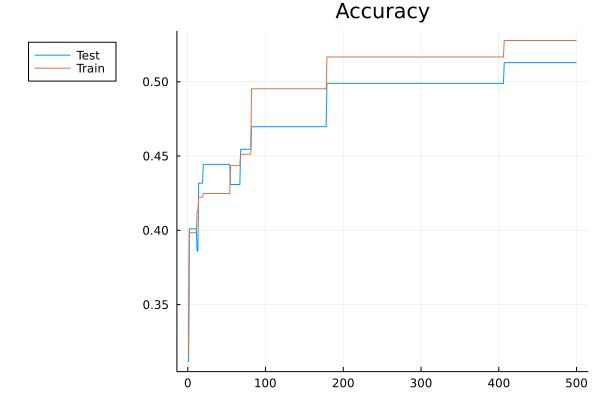

In [75]:
plot((1:maxCycle), save_resultTest,label="Test")
plot!((1:maxCycle), save_resultTrain,label = "Train", title = "Accuracy", legend = :outertopleft)